## Shampoo Sales Dataset

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
 
def parser(x):
	return pd.to_datetime(x)
 
#series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = pd.read_csv('shampoo-sales.csv', index_col=0, parse_dates=[0], date_parser=parser)
## Alternatively
## pd.to_datetime(series.index)     #if want to handle datetime conversion outside read_csv

plt.rcParams["figure.figsize"] = (20,10)
print(series.head())
series.plot()
plt.show()

            Sales
Date             
2000-01-01  266.0
2000-02-01  145.9
2000-03-01  183.1
2000-04-01  119.3
2000-05-01  180.3


<Figure size 2000x1000 with 1 Axes>

In [13]:
series.dtypes

Sales    float64
dtype: object

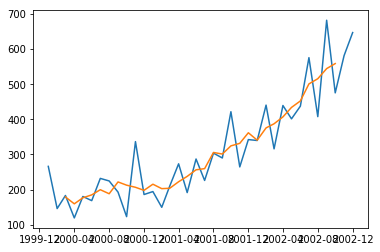

In [2]:

plt.plot( series)
plt.plot( series.rolling(5).mean().shift(-2))
plt.show();

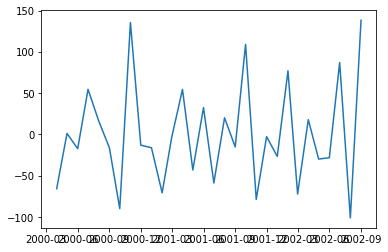

In [3]:
plt.plot(series-series.rolling(7).mean().shift(-3))
plt.show()

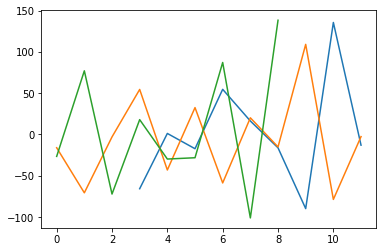

In [4]:
diff=series-series.rolling(7).mean().shift(-3)
plt.plot(diff['2000-01-01':'2000-12-31'].values)
plt.plot(diff['2001-01-01':'2001-12-31'].values)
plt.plot(diff['2002-01-01':'2002-12-31'].values)
plt.show()

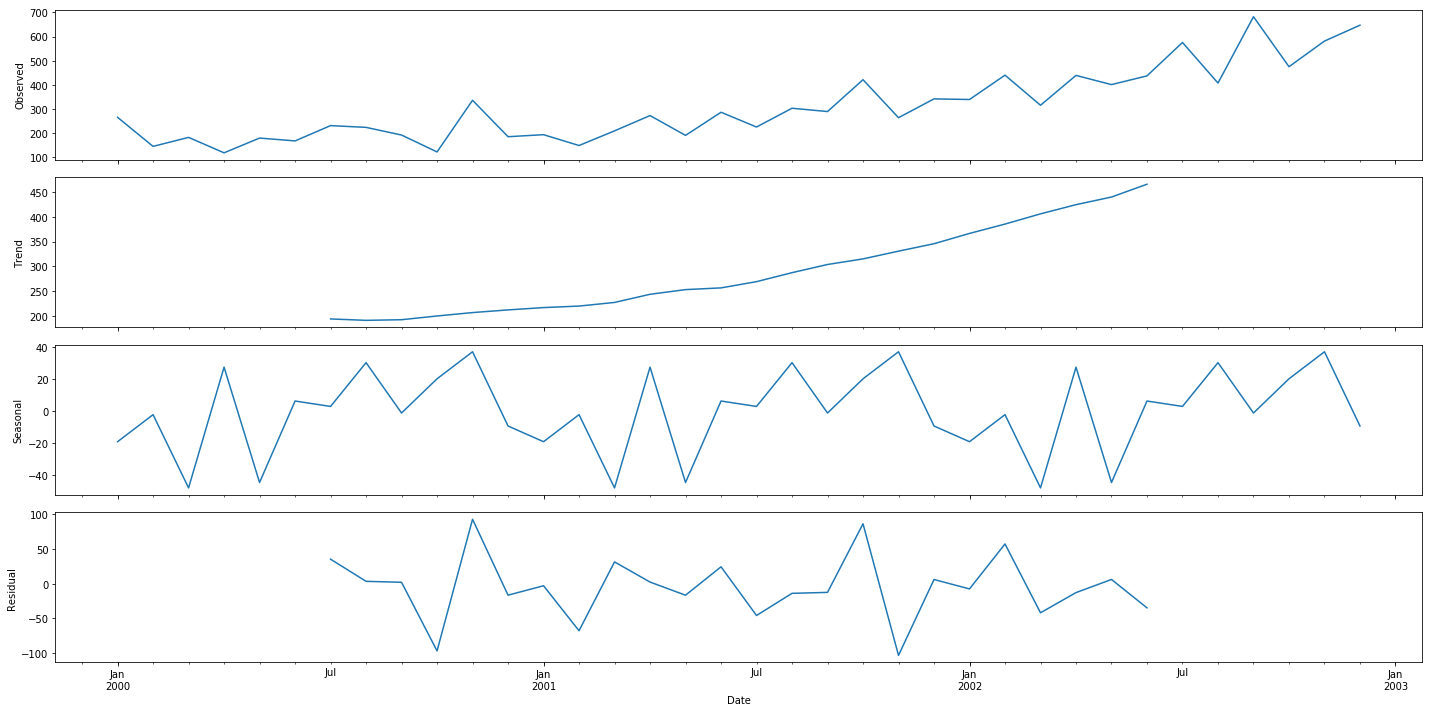

In [12]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (20,10)
result = seasonal_decompose(series, model='additive')
result.plot()
pyplot.show()

In [6]:

series.Sales

Date
2000-01-01    266.0
2000-02-01    145.9
2000-03-01    183.1
2000-04-01    119.3
2000-05-01    180.3
2000-06-01    168.5
2000-07-01    231.8
2000-08-01    224.5
2000-09-01    192.8
2000-10-01    122.9
2000-11-01    336.5
2000-12-01    185.9
2001-01-01    194.3
2001-02-01    149.5
2001-03-01    210.1
2001-04-01    273.3
2001-05-01    191.4
2001-06-01    287.0
2001-07-01    226.0
2001-08-01    303.6
2001-09-01    289.9
2001-10-01    421.6
2001-11-01    264.5
2001-12-01    342.3
2002-01-01    339.7
2002-02-01    440.4
2002-03-01    315.9
2002-04-01    439.3
2002-05-01    401.3
2002-06-01    437.4
2002-07-01    575.5
2002-08-01    407.6
2002-09-01    682.0
2002-10-01    475.3
2002-11-01    581.3
2002-12-01    646.9
Name: Sales, dtype: float64

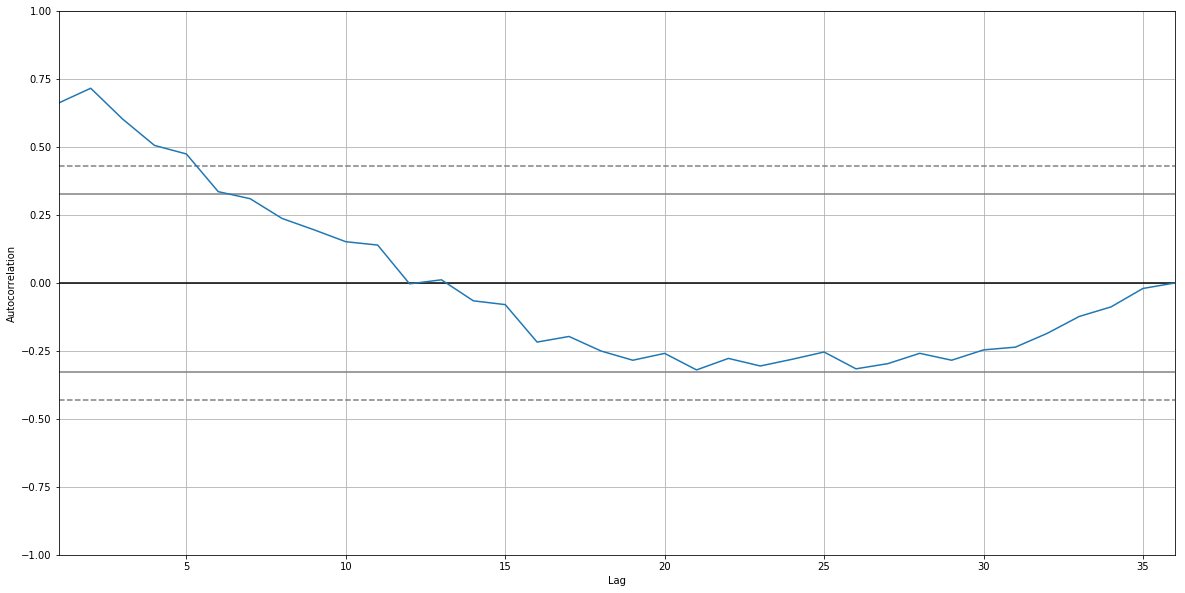

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

## ARIMA

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Wed, 08 Aug 2018   AIC                            406.340
Time:                        11:29:17   BIC                            417.227
Sample:                    02-01-2000   HQIC                           410.098
                         - 12-01-2002                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

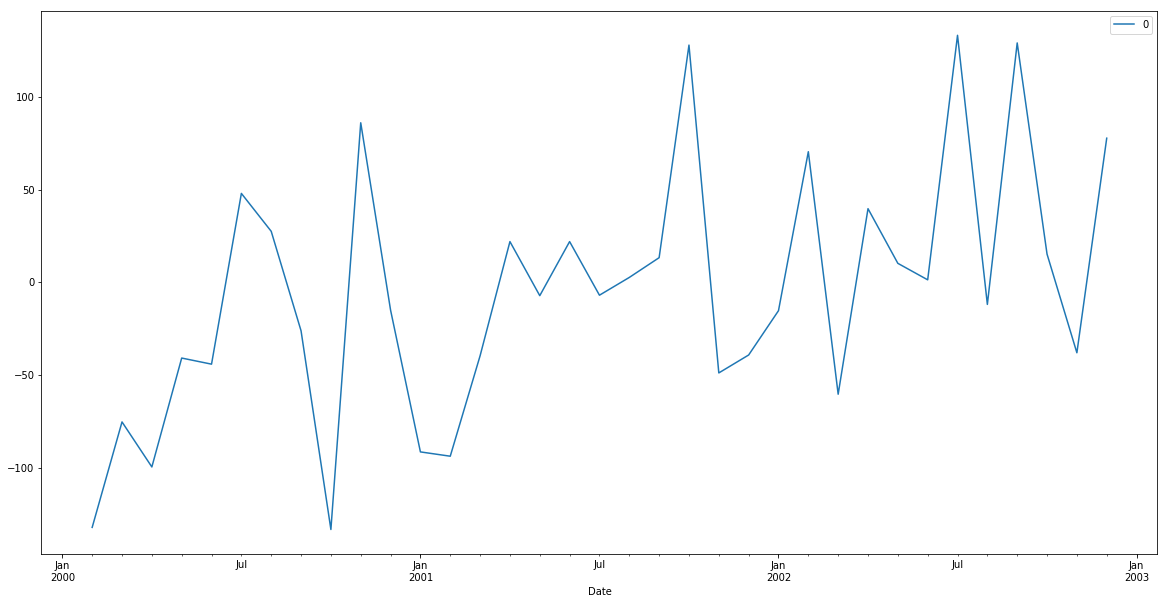

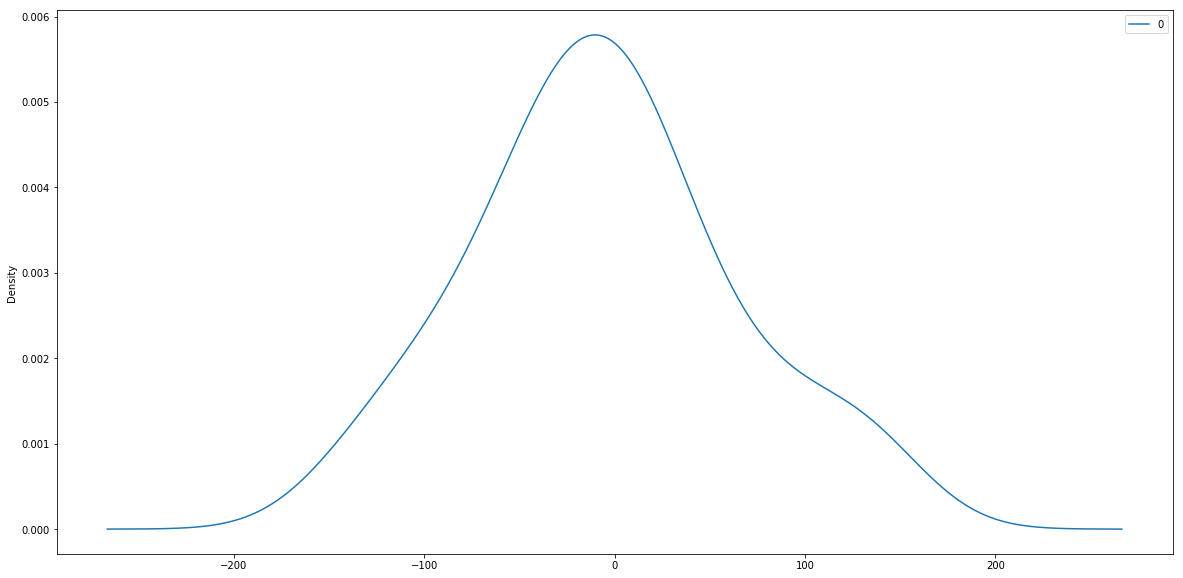

                0
count   35.000000
mean    -5.495218
std     68.132882
min   -133.296637
25%    -42.477890
50%     -7.186512
75%     24.748330
max    133.237936


In [8]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

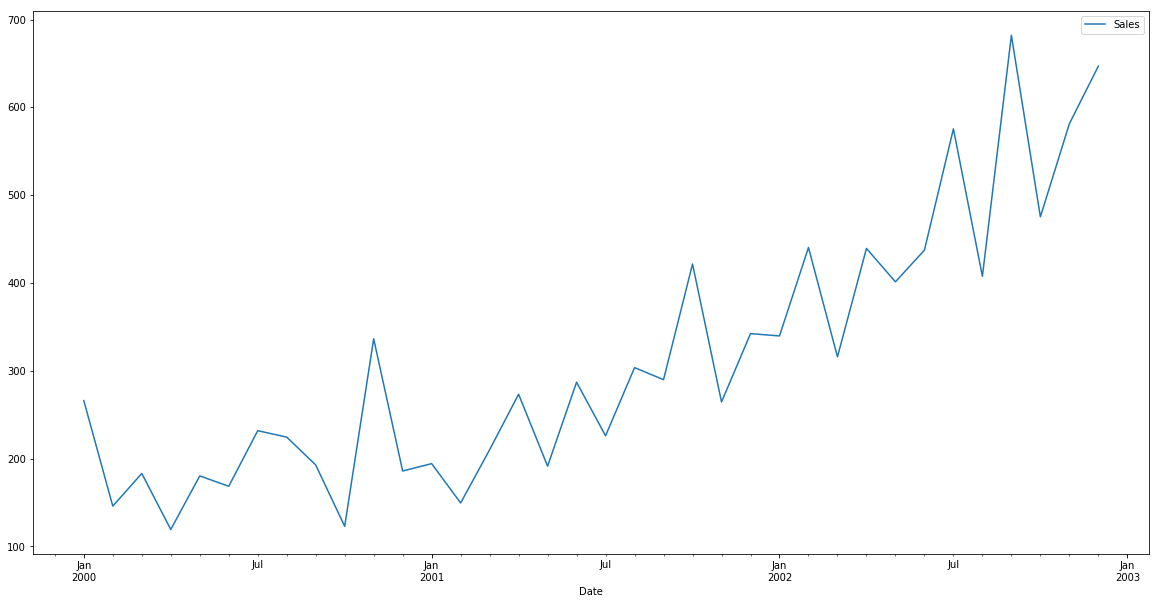

In [9]:
series.plot()
plt.show()

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

## Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

predicted=349.117636, expected=342.300000
predicted=306.513010, expected=339.700000
predicted=387.376466, expected=440.400000
predicted=348.154255, expected=315.900000
predicted=386.308811, expected=439.300000
predicted=356.082028, expected=401.300000
predicted=446.379518, expected=437.400000
predicted=394.737242, expected=575.500000
predicted=434.915541, expected=407.600000
predicted=507.923456, expected=682.000000
predicted=435.482818, expected=475.300000
predicted=652.743768, expected=581.300000
predicted=546.343465, expected=646.900000
Test MSE: 6958.327


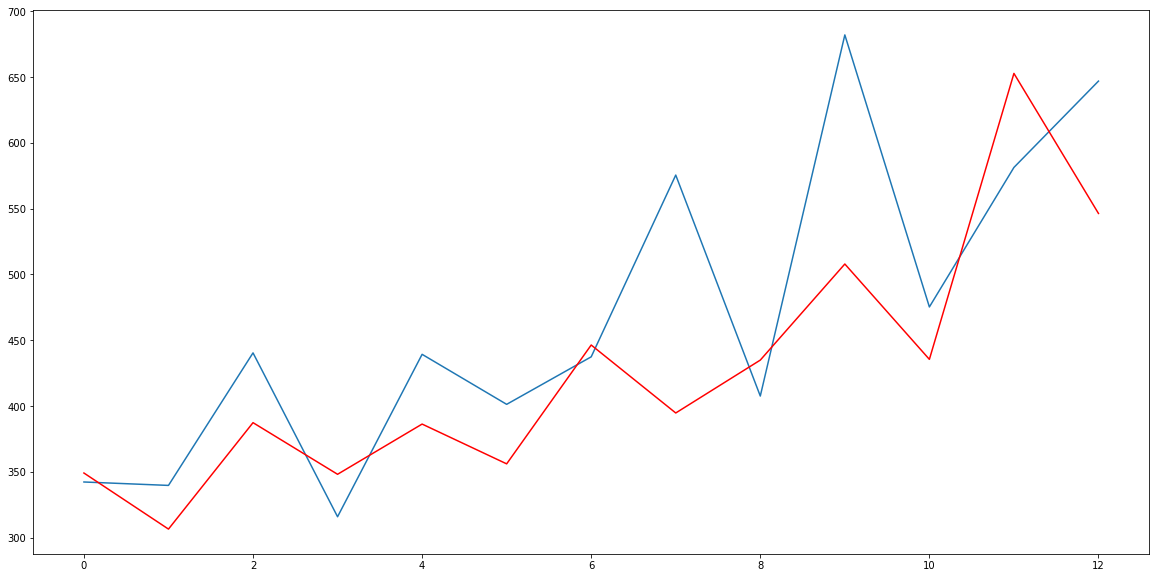

In [10]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Configuring an ARIMA Model
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology.

This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

In summary, the steps of this process are as follows:

Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.
Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.
The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).

The process was described in the classic 1970 textbook on the topic titled Time Series Analysis: Forecasting and Control by George Box and Gwilym Jenkins. An updated 5th edition is now available if you are interested in going deeper into this type of model and methodology.

Given that the model can be fit efficiently on modest-sized time series datasets, grid searching parameters of the model can be a valuable approach.

I have a question:

– We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero mean.
What if the residuals are not normally distributed?

REPLY: It may mean that you could improve your model with some data transform, perhaps something like a boxcox?

## Atmospheric CO2 data set

In [25]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [26]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [27]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


In [33]:
y.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01',
               '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01',
               '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', length=526, freq='MS')

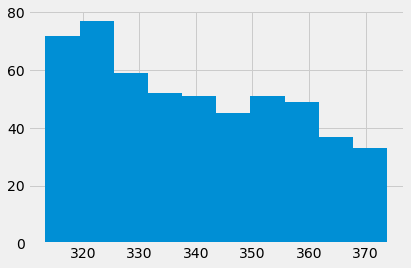

In [40]:
y.hist()
plt.show()

In [28]:
type(y)

pandas.core.series.Series

In [41]:
y.isnull().sum()

0

In [42]:
y[y>350]

1986-05-01    350.080
1987-04-01    350.850
1987-05-01    351.740
1987-06-01    351.150
1988-01-01    350.400
1988-02-01    351.775
1988-03-01    352.125
1988-04-01    353.580
1988-05-01    354.175
1988-06-01    353.750
1988-07-01    352.220
1988-08-01    350.300
1988-12-01    351.360
1989-01-01    352.775
1989-02-01    353.000
1989-03-01    353.600
1989-04-01    355.360
1989-05-01    355.600
1989-06-01    355.125
1989-07-01    353.860
1989-08-01    351.575
1989-10-01    350.050
1989-11-01    351.200
1989-12-01    352.480
1990-01-01    353.650
1990-02-01    354.650
1990-03-01    355.480
1990-04-01    356.175
1990-05-01    357.075
1990-06-01    356.080
               ...   
1999-07-01    369.000
1999-08-01    366.700
1999-09-01    364.675
1999-10-01    365.140
1999-11-01    366.650
1999-12-01    367.900
2000-01-01    369.020
2000-02-01    369.375
2000-03-01    370.400
2000-04-01    371.540
2000-05-01    371.650
2000-06-01    371.625
2000-07-01    369.940
2000-08-01    367.950
2000-09-01

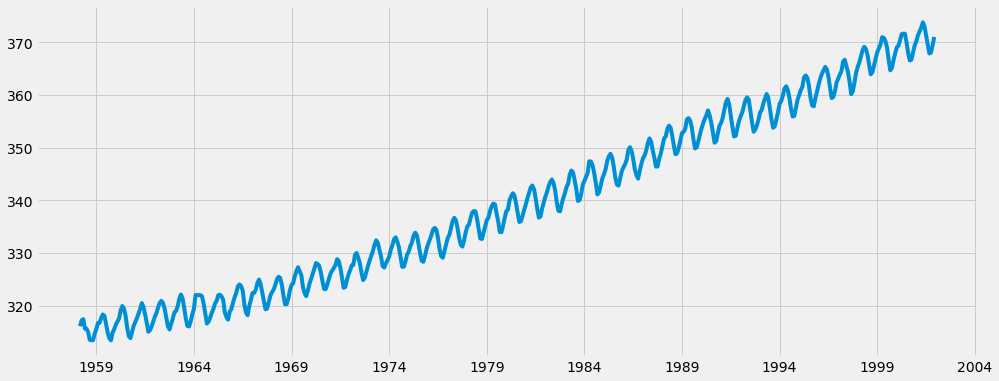

In [48]:
y.plot(figsize=(15, 6))
#plt.xlim('1965-01-01','1970-01-01')
plt.show()

In [49]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624044943
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727637575
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320024
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878580283596
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913192131
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755565863
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327777407
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067050425
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.41747168552
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1090.0113428349287
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.431544732111
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893594177
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.091298872047
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.221119919409
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.7938545681309
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501757829037
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283759260472
ARIMA

In [14]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3181      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


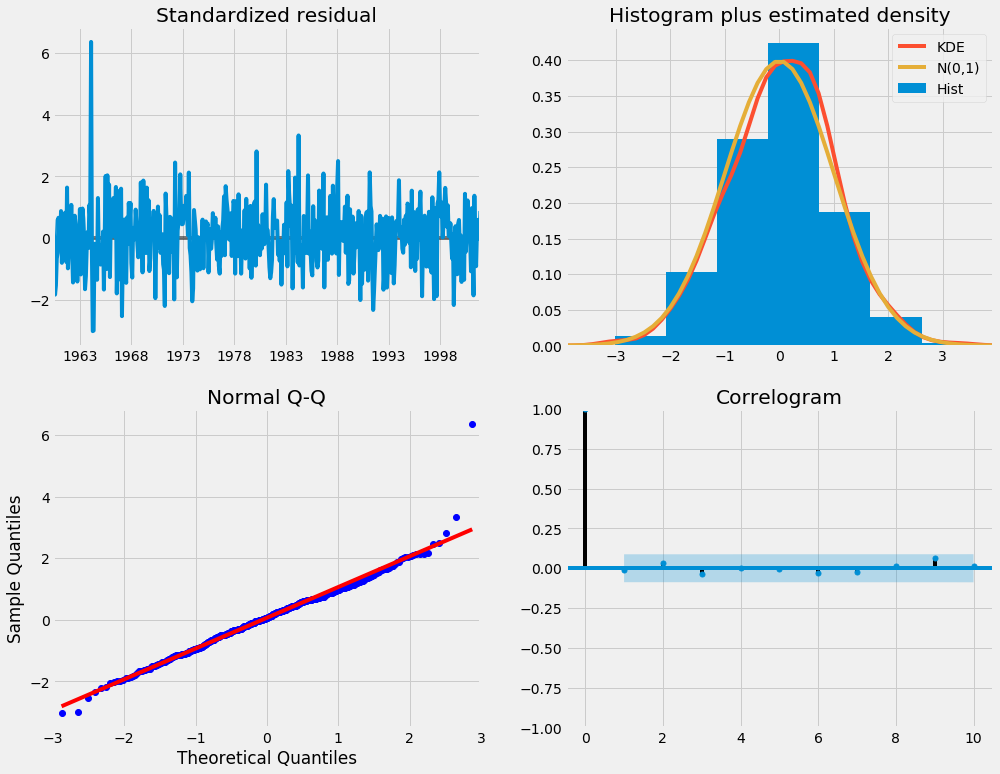

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [17]:
pred_ci

,lower co2,upper co2
1998-01-01,364.453358,365.675233
1998-02-01,365.373497,366.595371
1998-03-01,366.404741,367.626615
1998-04-01,367.908496,369.130369
1998-05-01,368.389522,369.611396
1998-06-01,367.802556,369.024429
1998-07-01,366.481983,367.703856
1998-08-01,364.754332,365.976206
1998-09-01,363.200085,364.421958
1998-10-01,363.378475,364.600349


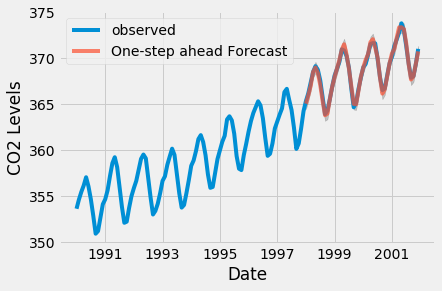

In [18]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [51]:
results.fittedvalues

1958-03-01      0.000000
1958-04-01    349.622366
1958-05-01    322.539211
1958-06-01    318.299102
1958-07-01    315.464303
1958-08-01    315.600084
1958-09-01    314.836046
1958-10-01    313.245840
1958-11-01    313.373360
1958-12-01    313.416993
1959-01-01    314.906708
1959-02-01    315.662529
1959-03-01    526.044972
1959-04-01    277.035854
1959-05-01    317.856390
1959-06-01    316.528418
1959-07-01    318.081967
1959-08-01    315.781502
1959-09-01    313.418057
1959-10-01    313.774474
1959-11-01    313.389607
1959-12-01    316.208451
1960-01-01    316.290302
1960-02-01    317.564335
1960-03-01    316.887602
1960-04-01    318.524630
1960-05-01    319.598783
1960-06-01    319.206950
1960-07-01    318.083612
1960-08-01    316.509649
                 ...    
1999-07-01    368.880876
1999-08-01    366.980759
1999-09-01    365.042035
1999-10-01    364.998633
1999-11-01    366.467883
1999-12-01    367.997576
2000-01-01    368.993978
2000-02-01    369.819825
2000-03-01    370.447680


In [52]:
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


In [54]:
results.resid

1958-03-01    316.100000
1958-04-01    -32.422366
1958-05-01     -5.105878
1958-06-01     -2.674102
1958-07-01      0.160697
1958-08-01     -0.650084
1958-09-01     -1.336046
1958-10-01      0.179160
1958-11-01      0.051640
1958-12-01      1.283007
1959-01-01      0.593292
1959-02-01      1.037471
1959-03-01   -209.311639
1959-04-01     40.639146
1959-05-01      0.468610
1959-06-01      1.496582
1959-07-01     -1.556967
1959-08-01     -0.881502
1959-09-01      0.406943
1959-10-01     -0.374474
1959-11-01      1.485393
1959-12-01     -0.683451
1960-01-01      0.089698
1960-02-01     -0.589335
1960-03-01      0.687398
1960-04-01      0.595370
1960-05-01      0.326217
1960-06-01      0.243050
1960-07-01     -0.023612
1960-08-01     -0.734649
                 ...    
1999-07-01      0.119124
1999-08-01     -0.280759
1999-09-01     -0.367035
1999-10-01      0.141367
1999-11-01      0.182117
1999-12-01     -0.097576
2000-01-01      0.026022
2000-02-01     -0.444825
2000-03-01     -0.047680


In [19]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [20]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

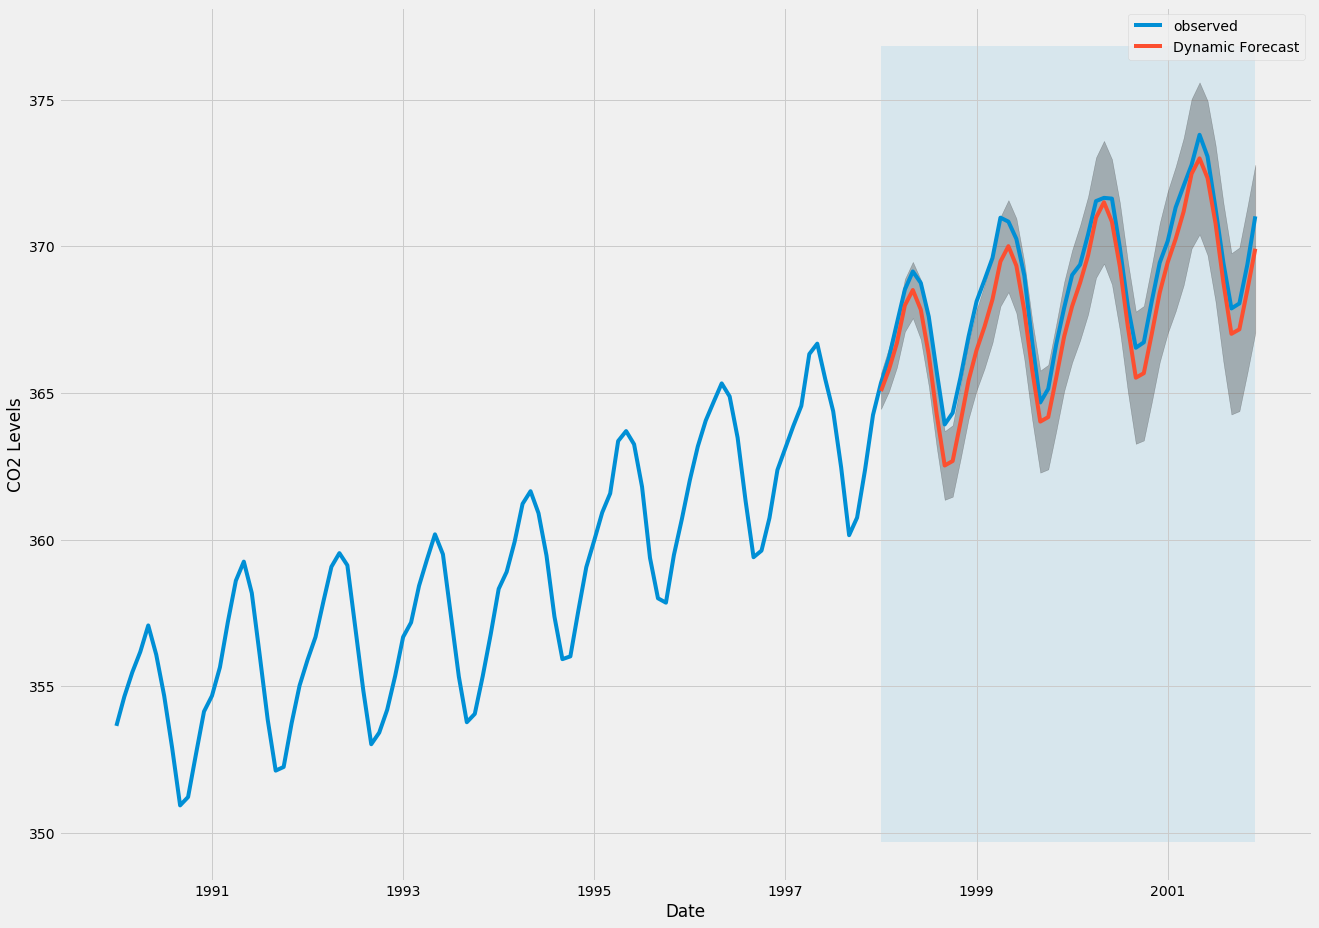

In [21]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [22]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [55]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

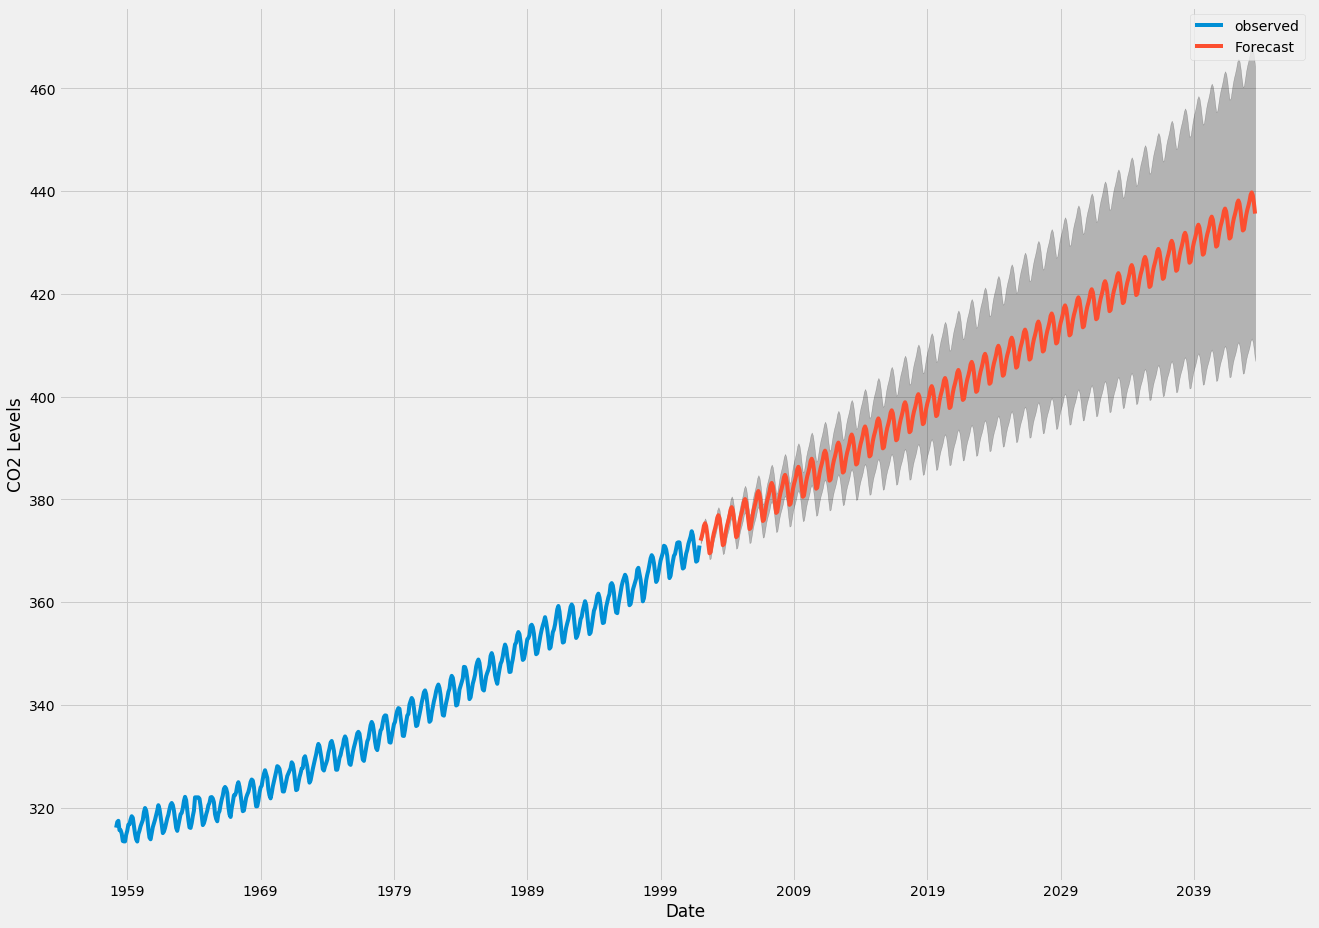

In [56]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()